In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2
import pvlib
import pyproj
import pandas as pd

import common.loss_utils as loss_utils


In [3]:
p = pathlib.Path('data/coords.npz')
f = np.load(p)
x_osgb = f['x_osgb']
y_osgb = f['y_osgb']

In [4]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [5]:
times.shape, data.shape, x_osgb.shape, y_osgb.shape

((18354,), (18354, 325, 400), (325, 400), (325, 400))

In [18]:
list(f.keys())

['times', 'data']

In [9]:
# OSGB is also called "OSGB 1936 / British National Grid -- United
# Kingdom Ordnance Survey".  OSGB is used in many UK electricity
# system maps, and is used by the UK Met Office UKV model.  OSGB is a
# Transverse Mercator projection, using 'easting' and 'northing'
# coordinates which are in meters.  See https://epsg.io/27700
OSGB = 27700

# WGS84 is short for "World Geodetic System 1984", used in GPS. Uses
# latitude and longitude.
WGS84 = 4326
WGS84_CRS = f"EPSG:{WGS84}"

class Transformers:
    """
    Class to store transformation from one Grid to another.
    Its good to make this only once, but need the
    option of updating them, due to out of data grids.
    """

    def __init__(self):
        """Init"""
        self._osgb_to_lat_lon = None
        self._lat_lon_to_osgb = None
        self.make_transformers()

    def make_transformers(self):
        """
        Make transformers
         Nice to only make these once, as it makes calling the functions below quicker
        """
        self._osgb_to_lat_lon = pyproj.Transformer.from_crs(crs_from=OSGB, crs_to=WGS84)
        self._lat_lon_to_osgb = pyproj.Transformer.from_crs(crs_from=WGS84, crs_to=OSGB)

    @property
    def osgb_to_lat_lon(self):
        """OSGB to lat-lon property"""
        return self._osgb_to_lat_lon

    @property
    def lat_lon_to_osgb(self):
        """lat-lon to OSGB property"""
        return self._lat_lon_to_osgb
    
transformers = Transformers()

def osgb_to_lat_lon(x, y):
    """
    Change OSGB coordinates to lat, lon
    Args:
        x: osgb east-west
        y: osgb north-south
    Return: 2-tuple of latitude (north-south), longitude (east-west).
    """
    return transformers.osgb_to_lat_lon.transform(x, y)

In [78]:
def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175


class DataFetcher:
    def __init__(self, times, data, x_osgb, y_osgb, random_state=7):
        self.times = times
        self.data = data
        self.x_osgb = x_osgb
        self.y_osgb = y_osgb
        self.generator = np.random.RandomState(random_state)
        self.bad_count = 0
        self.skips = 0

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
#         rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
#         rand_y = self.generator.randint(0, input_slice.shape[1] - 128)
        rand_x = (input_slice.shape[2] - 128) // 2
        rand_y = (input_slice.shape[1] - 128) // 2

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]
        
        x_cord = self.x_osgb[rand_y + 64, rand_x + 64]
        y_cord = self.y_osgb[rand_y + 64, rand_x + 64]
        lat, lon = osgb_to_lat_lon(x_cord, y_cord)
        return in_crop, target_crop, lat, lon

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
#             self.skips += 1
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y, lat, lon = self._get_crop(src, trg)
        # we don't need to localize because the time is already UTC, which is also UK time
        tstart = pd.Timestamp(tstart)
        tend = pd.Timestamp(tend)
        e1 = pvlib.solarposition.get_solarposition(tstart, center_lat, center_lon).elevation.values[0]
        e2 = pvlib.solarposition.get_solarposition(tend, center_lat, center_lon).elevation.values[0]
        if e1 < 10 or e2 < 10:
#             self.bad_count += 1
            return self.__getitem__((index + 35) % len(self))
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data, x_osgb, y_osgb)

In [60]:
for i in tqdm.tqdm(range(len(ds))):
    ds[i]

100%|██████████| 18319/18319 [03:32<00:00, 86.30it/s]


In [61]:
ds.bad_count, ds.skips, len(ds)

(1718, 9244, 18319)

In [63]:
for i in tqdm.tqdm(range(len(ds))):
    ds[i]

  0%|          | 38/18319 [00:00<03:46, 80.63it/s]


ValueError: 38

In [67]:
times[38], times[38+35]

(numpy.datetime64('2021-03-23T13:10:00.000000000'),
 numpy.datetime64('2020-07-26T10:00:00.000000000'))

In [69]:
times[38+35], times[38+35+35]

(numpy.datetime64('2020-07-26T10:00:00.000000000'),
 numpy.datetime64('2020-07-26T12:55:00.000000000'))

In [66]:
times[37:37+40]

array(['2021-03-23T13:05:00.000000000', '2021-03-23T13:10:00.000000000',
       '2021-03-23T13:15:00.000000000', '2021-03-23T13:20:00.000000000',
       '2021-03-23T13:25:00.000000000', '2021-03-23T13:30:00.000000000',
       '2021-03-23T13:35:00.000000000', '2021-03-23T13:40:00.000000000',
       '2021-03-23T13:45:00.000000000', '2021-03-23T13:50:00.000000000',
       '2021-03-23T13:55:00.000000000', '2021-03-23T14:00:00.000000000',
       '2021-03-23T14:05:00.000000000', '2021-03-23T14:10:00.000000000',
       '2021-03-23T14:15:00.000000000', '2021-03-23T14:20:00.000000000',
       '2021-03-23T14:25:00.000000000', '2021-03-23T14:30:00.000000000',
       '2021-03-23T14:35:00.000000000', '2021-03-23T14:40:00.000000000',
       '2021-03-23T14:45:00.000000000', '2021-03-23T14:50:00.000000000',
       '2021-03-23T14:55:00.000000000', '2021-03-23T15:00:00.000000000',
       '2021-03-23T15:05:00.000000000', '2021-03-23T15:10:00.000000000',
       '2021-03-23T15:15:00.000000000', '2021-03-23

In [71]:
x, y = ds[0]

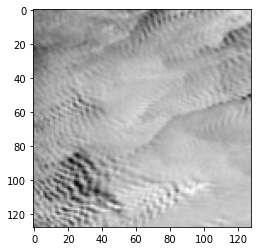

In [72]:
plt.imshow(x[-1], cmap='gray')

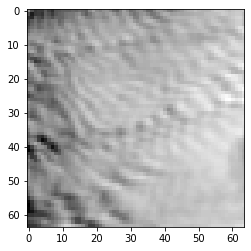

In [73]:
plt.imshow(y[-1], cmap='gray')

In [74]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [75]:
def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    ).item()

In [81]:
LOOKS = len(ds)


In [82]:
pers_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = x[-1:,32:96,32:96]
    preds = np.tile(preds, (y.shape[0], 1, 1))
    score = get_mssim(preds, y)
    pers_scores.append(score)

100%|██████████| 18319/18319 [05:59<00:00, 50.97it/s]


In [84]:
pers_scores

[0.46117401123046875,
 0.5140397548675537,
 0.977804958820343,
 0.567531406879425,
 0.8914411664009094,
 0.5628999471664429,
 0.7348759770393372,
 0.8163555264472961,
 0.49486780166625977,
 0.639159619808197,
 0.7493903636932373,
 0.6738629341125488,
 0.35032570362091064,
 0.5422611236572266,
 0.5171372294425964,
 0.798901379108429,
 0.3552461862564087,
 0.6205950379371643,
 0.8163555264472961,
 0.71268230676651,
 0.6277479529380798,
 0.3215610980987549,
 0.7548077702522278,
 0.4425085783004761,
 0.5587491393089294,
 0.5159936547279358,
 0.945101261138916,
 0.10066640377044678,
 0.6946437358856201,
 0.6716799736022949,
 0.8863620758056641,
 0.7924736142158508,
 0.3962724208831787,
 0.45557737350463867,
 0.8101380467414856,
 0.4267216920852661,
 0.5402981638908386,
 0.9963736534118652,
 0.6264194846153259,
 0.9216048717498779,
 0.42505645751953125,
 0.39313793182373047,
 0.8218061327934265,
 0.6938662528991699,
 0.5286176800727844,
 0.43331992626190186,
 0.4504282474517822,
 0.659247696

In [83]:
np.mean(pers_scores)

0.5956514196154059

In [15]:
np.mean(pers_scores)

0.618091509103775

In [55]:
optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    flow = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        pyr_scale=0.5, levels=3, winsize=15, 
        iterations=10, poly_n=5, poly_sigma=1.2, 
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    )
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        cur = warp_flow(cur, flow)
        preds[j] = cur[32:96,32:96]
    
    score = get_mssim(preds, y)
    optical_flow_scores.append(score)


100%|██████████| 500/500 [00:08<00:00, 58.85it/s]


In [54]:
np.mean(optical_flow_scores)

0.6000355912446975